### Algoritmo de Shor para $N = 15$

En este caso se simula y emula el algoritmo de Shor para $N=15$ y $a=13$ usando el circuito de la figura (2).

* Carga de librerias

In [3]:
# Librerias Qiskit
from qiskit import *
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.extensions import *
from qiskit.circuit.library import QFT
# Plots
from qiskit.visualization import plot_histogram as plth

In [4]:
# Extras
import numpy as np

from math import pi, ceil, log, gcd
import pandas as pd
from fractions import Fraction
import random
random.seed(1) #Permite hacer simulaciones reproducibles con las misma probabilidades

In [5]:
#Cargar La cuenta en la IBM
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

* Construcción del circuito de la figura (2).

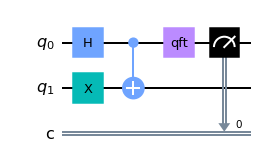

In [6]:
# Circuito de Shor

#Parametros
l = 1
k = 1
n = k+l

#Ensamblado
qr = QuantumRegister(n, 'q')
cr = ClassicalRegister(l, 'c')
qc = QuantumCircuit(qr, cr)

#Inicializacion
qc.x(-1)

# Superposicion de todos los estados x
qc.h(0)

# U
qc.cx(0,1)

# QFT inversa
qc.append(QFT(l, insert_barriers=True, inverse=True), qargs=[0]) # Que realmente es H pero a efectos practicos no hace mal verlo asi.

# Medida
qc.measure([qubit for qubit in range(l) ],[qubit for qubit in range(l) ])

# Dibujo
qc.draw(output="mpl") 

* Definición de funciones auxiliares

In [8]:
def printTable(backend, n_count=l):
    """
    Esta funcion toma la salida de un circuito cuantico simulado muchas veces y transforma lo valores
    a una tabla con la distintas fases e intentos para r. Ademas de decir el tiempo que tomo ejecutarlo
    """
    rows, measured_phases = [], []
    for output in counts:
        decimal = int(output, 2)
        phase = decimal/(2**n_count) 
        measured_phases.append(phase)
        frac = Fraction(phase).limit_denominator(15)
        rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}",f"{frac.numerator}/{frac.denominator}", frac.denominator])
    # Print the rows in a table
    print("Computador usado: ", backend, "\nTiempo tomado:", results.time_taken)
    headers=["Salida medida", "Fase", "Fraccion", "Intento de r"]
    df = pd.DataFrame(rows, columns=headers)
    print(df)
    
    # Ejecucion de nuestro circuito en el computador REAL
def runCircuit(backend_name):
    """
    Esta funcion toma el nombre de una computadora cuantica real de la IBM y corre el circuito simulado en la seccion anterior
    """
    backend = provider.get_backend(backend_name)# Escogemos los sistemas que se usarán en la práctica
    transpiled_qc = transpile(qc, backend, optimization_level=3)
    transpiled_qc = [transpiled_qc for i in range(9)]
    job = execute(transpiled_qc, backend=backend, shots=8192, optimization_level=3)
    job_monitor(job)
    return backend, job

### Simulación

En esta parte se simula el circuito en el QASM Simulator de Qiskit, básico para entender si es posible obtener los resultados correctos.

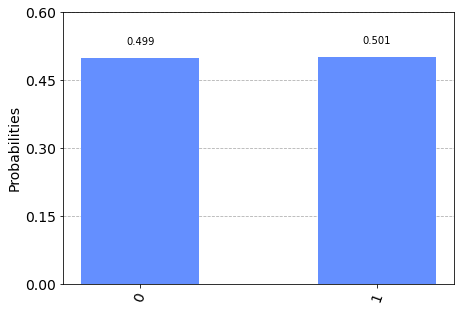

In [6]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend = backend, shots = 8192).result()
counts = results.get_counts()
plth(counts)

In [7]:
printTable(backend)

Computador usado:  qasm_simulator 
Tiempo tomado: 0.01998281478881836
       Salida medida        Fase Fraccion  Intento de r
0  1(bin) =   1(dec)  1/2 = 0.50      1/2             2
1  0(bin) =   0(dec)  0/2 = 0.00      0/1             1


Como vemos obtenemos $r=2$ con una probabilidad de $0.501$, no existe problema al escoger $1/2$ pues 1 y 2 son coprimos.Ademas $1/2$ converge sin problemas a 0.25.

Basta con hacer el último paso del algoritmo y verificar que $r=2$ funciona con la base $a=11$, obteniendo asi $p$ y $q$ con:

$$
p = gcd(11^{2/2}+1,15) = 3 \\
q = gcd(11^{2/2}-1,15) = 5
$$

Finalmente, $15=3.5$

### Emulación

Para la parte de emulación utilizaremos 3 computadores cuánticos de la IBM:
    
- IBMQ Santiago: https://quantum-computing.ibm.com/services?services=systems&systems=yours&system=ibmq_santiago
- IBMQ Quito: https://quantum-computing.ibm.com/services?services=systems&systems=yours&system=ibmq_quito
- IBMQ Bogota: https://quantum-computing.ibm.com/services?services=systems&systems=yours&system=ibmq_bogota
        
Cada circuito se emulará 10 veces, de allí obtendremos el promedio y la desviación estándard de las probabilidades de interés medidas.
También se tomará en cuenta el tiempo de ejecución total de los 10 circuitos.

Gráficamos la primera emulación a ver que clase de ruidos presenta.

##### IBMQ Santiago

In [10]:
backend0, job0 = runCircuit("ibmq_santiago")
results0 = job0.result()
counts0 = results0.get_counts()

Job Status: job has successfully run


In [18]:
probs = list()
for dict in counts0:
    probs.append((dict['1'])/8192.)
print(np.mean(probs),np.std(probs))
print(results0.time_taken)

0.4786783854166667 0.01474386146384331
26.217875719070435


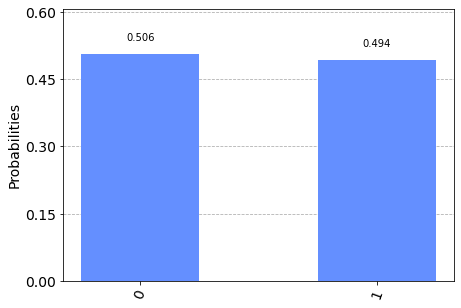

In [19]:
plth(counts0[0])

###### Resultados

* Tiempo de Ejecución: $26.217 s$
* Probabilidad de medir $r=2$: Promedio = $0.479$ , $\sigma$ = $0.015$     

##### IBMQ Quito

In [14]:
backend1, job1 = runCircuit("ibmq_quito")
results1 = job1.result()
counts1 = results1.get_counts()

Job Status: job has successfully run


In [24]:
probs = list()
for dict in counts1:
    probs.append((dict['1'])/8192.)
print(np.mean(probs),np.std(probs))
print(results1.time_taken)

0.4619683159722222 0.025908518300832725
23.16439414024353


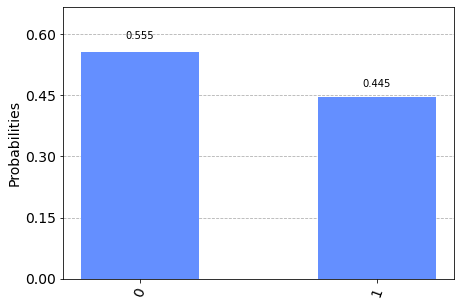

In [25]:
plth(counts1[0])

###### Resultados

* Tiempo de Ejecución: $23.164 s$
* Probabilidad de medir $r=2$: Promedio = $0.462$ , $\sigma$ = $0.026$     

##### IBMQ Bogota

In [16]:
backend2, job2 = runCircuit("ibmq_bogota")
results2 = job2.result()
counts2 = results2.get_counts()

Job Status: job has successfully run


In [22]:
probs = list()
for dict in counts2:
    probs.append((dict['1'])/8192.)
print(np.mean(probs),np.std(probs))
print(results2.time_taken)

0.4439968532986111 0.03523512940623692
26.204873085021973


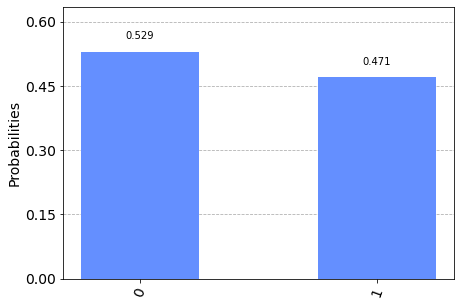

In [23]:
plth(counts2[0])

###### Resultados

* Tiempo de Ejecución: $26.205 s$
* Probabilidad de medir $r=2$: Promedio = $0.444$ , $\sigma$ = $0.035$     